In [2]:
# Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/Colab Notebooks/DisseDATA")

Mounted at /content/drive/


In [3]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [4]:
!pip install linearmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00


In [5]:

df_final = pd.read_excel('FR copy.xlsx')

tesla_index = df_final[df_final['Company'] == 'Tesla'].index

df_final.loc[tesla_index, 'Net sales'] = df_final.loc[tesla_index, 'Net sales'] / 1000
df_final.loc[tesla_index, 'Gross profit'] = df_final.loc[tesla_index, 'Gross profit'] / 1000

df_final.sort_values(by=['Company', 'Year', 'Quarter'], inplace=True)

df_final['Net sales t-1'] = df_final.groupby('Company')['Net sales'].shift(1)

df_final['Total liability'] = df_final['Total assets'] - df_final['Total shareholders\' equity']

# Calculate Debt-to-Equity Ratio
df_final['Debt-to-Equity'] = df_final['Total liability'] / df_final['Total shareholders\' equity']
df_final.head(2)

<ipython-input-5-4fee6381cd85>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  939.88    954.976   936.789  1214.38   1147.048  1270.017  2298.436
  2284.631  2696.27   2789.557  2984.675  3288.249  3408.751  4002.231
  6824.413  7225.873  4541.     6350.     6303.     7384.     5985.
  6036.     8771.    10744.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_final.loc[tesla_index, 'Net sales'] = df_final.loc[tesla_index, 'Net sales'] / 1000


,Company,Year,Quarter,Net sales,Net sales growth rate,Gross profit,Operating income,Net income,Total assets,Total shareholders' equity,...,MDA sentiment t-4,average tweet sentiment t-1,meidan tweet sentiment t-1,average tweet sentiment t-2,meidan tweet sentiment t-2,average tweet sentiment t-3,average tweet sentiment t-4,Net sales t-1,Total liability,Debt-to-Equity
24,Amazon,2015,1,22717.0,NaN,7322.0,255.0,-57.0,50075.0,10873.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39202.0,3.605445
25,Amazon,2015,2,23185.0,0.020601,8025.0,464.0,92.0,52440.0,11768.0,...,NaN,0.355567,0.446747,NaN,NaN,NaN,NaN,22717.0,40672.0,3.456152


# REgression

In [6]:
df_final_clean = df_final.dropna(subset=['MDA sentiment t-1','average tweet sentiment t-1',"meidan tweet sentiment t-1"])

print(df_final_clean.isna().sum())


Company                         0
Year                            0
Quarter                         0
Net sales                       0
Net sales growth rate           0
Gross profit                    0
Operating income                0
Net income                      0
Total assets                    0
Total shareholders' equity      0
ROA                             0
ROE                             0
MDA sentiment t-1               0
MDA sentiment t-2               5
MDA sentiment t-3              10
MDA sentiment t-4              15
average tweet sentiment t-1     0
meidan tweet sentiment t-1      0
average tweet sentiment t-2     5
meidan tweet sentiment t-2      5
average tweet sentiment t-3    10
average tweet sentiment t-4    15
Net sales t-1                   0
Total liability                 0
Debt-to-Equity                  0
dtype: int64


# t-1

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import RandomEffects

df_final_clean1 = df_final_clean.set_index(['Company', 'Year'])

df_final_clean1['Scaled Total assets'] = df_final_clean1['Total assets'] / 10000
df_final_clean1['Net sales'] = df_final_clean1['Net sales'] / 10000
df_final_clean1['Scaled Total liability'] = df_final_clean1['Total liability'] / 10000
df_final_clean1['Scaled Net sales t-1'] = df_final_clean1['Net sales t-1'] / 10000
df_final_clean1['ln_Total_assets'] = np.log(df_final_clean1['Total assets'])
df_final_clean1['ln_Net sales'] = np.log(df_final_clean1['Net sales'])


df_final_clean1['interaction'] = df_final_clean1['MDA sentiment t-1'] * df_final_clean1['average tweet sentiment t-1']


X = df_final_clean1[['average tweet sentiment t-1', 'ln_Total_assets', 'MDA sentiment t-1', 'Debt-to-Equity', 'Net sales t-1', 'interaction']]
X = sm.add_constant(X)  # Add constant term to the model
y = df_final_clean1['Net sales']


model = RandomEffects(y, X)
re_results = model.fit()


print(re_results.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:              Net sales   R-squared:                        0.8209
Estimator:              RandomEffects   R-squared (Between):              0.9913
No. Observations:                 100   R-squared (Within):               0.2938
Date:                Wed, Sep 04 2024   R-squared (Overall):              0.8209
Time:                        14:23:52   Log-likelihood                   -138.06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      71.054
Entities:                           5   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                    F(6,93)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             71.054
                            

In [17]:
import numpy as np
import scipy.stats
from linearmodels.panel import PanelOLS, RandomEffects

fe_model = PanelOLS(y, X, entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
re_model = RandomEffects(y, X).fit()

b = fe_model.params
B = re_model.params
v_b = fe_model.cov
v_B = re_model.cov

diff = b - B
var_diff = v_b - v_B

chi2 = diff.T @ np.linalg.inv(var_diff) @ diff
p_value = 1 - scipy.stats.chi2.cdf(chi2, len(b))

print(f"Chi-squared: {chi2}")
print(f"P-value: {p_value}")



Chi-squared: -5.2767434185444735
P-value: 1.0


# OLS

In [138]:
import pandas as pd



import statsmodels.api as sm
df_final_clean['Scaled Total assets'] = df_final['Total assets'] / 10000
df_final_clean['Scaled  Net sales'] = df_final_clean['Net sales'] / 10000
df_final_clean['Scaled Total liability'] = df_final['Total liability'] / 10000
df_final_clean['Scaled Net sales t-1'] = df_final['Net sales t-1'] / 10000
df_final_clean['ln_Total_assets'] = np.log(df_final_clean['Total assets'])
df_final_clean['ln_Net sales'] = np.log(df_final['Net sales'])

df_final_clean['interaction'] = df_final_clean['MDA sentiment t-1'] * df_final_clean['average tweet sentiment t-1']

X = sm.add_constant(df_final_clean[['ln_Total_assets','interaction','Debt-to-Equity']])
y = df_final_clean["Scaled  Net sales"]
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Scaled  Net sales   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     18.16
Date:                Sun, 25 Aug 2024   Prob (F-statistic):           2.06e-09
Time:                        11:55:25   Log-Likelihood:                -201.59
No. Observations:                 100   AIC:                             411.2
Df Residuals:                      96   BIC:                             421.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.1136      1.529     

In [54]:
import pandas as pd



import statsmodels.api as sm
df_final_clean['Scaled Total assets'] = df_final['Total assets'] / 10000
df_final_clean['Scaled  Net sales'] = df_final_clean['Net sales'] / 10000
df_final_clean['Scaled Total liability'] = df_final['Total liability'] / 10000
df_final_clean['Scaled Net sales t-1'] = df_final['Net sales t-1'] / 10000
df_final_clean['ln_Total_assets'] = np.log(df_final_clean['Total assets'])
df_final_clean['ln_Net sales'] = np.log(df_final['Net sales'])

df_final_clean['interaction'] = df_final_clean['MDA sentiment t-1'] * df_final_clean['average tweet sentiment t-1']

X = sm.add_constant(df_final_clean[['average tweet sentiment t-1', 'ln_Total_assets','MDA sentiment t-1','Debt-to-Equity','Net sales t-1']])
y = df_final_clean["Scaled  Net sales"]
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Scaled  Net sales   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     85.77
Date:                Sun, 25 Aug 2024   Prob (F-statistic):           1.77e-33
Time:                        11:04:32   Log-Likelihood:                -138.26
No. Observations:                 100   AIC:                             288.5
Df Residuals:                      94   BIC:                             304.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [55]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd


X = sm.add_constant(df_final_clean[['average tweet sentiment t-1', 'ln_Total_assets','MDA sentiment t-1','Debt-to-Equity']])


vif_data = pd.DataFrame()
vif_data["feature"] = X.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                       feature         VIF
0                        const  138.444264
1  average tweet sentiment t-1    1.334766
2              ln_Total_assets    2.298282
3            MDA sentiment t-1    1.039531
4               Debt-to-Equity    1.839692


## t-2

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import RandomEffects


df_final_clean2 = df_final_clean.set_index(['Company', 'Year'])

df_final_clean2 = df_final_clean2.dropna(subset=['MDA sentiment t-2','average tweet sentiment t-2'])

df_final_clean2['Total assets'] = df_final_clean2['Total assets'].replace(0, np.nan)
df_final_clean2['Net sales'] = df_final_clean2['Net sales'].replace(0, np.nan)

df_final_clean2['ln_Total_assets'] = np.log(df_final_clean2['Total assets'])
df_final_clean2['ln_Net sales'] = np.log(df_final_clean2['Net sales'])

df_final_clean2['Scaled Total assets'] = df_final_clean2['Total assets'] / 10000
df_final_clean2['Net sales'] = df_final_clean2['Net sales'] / 10000
df_final_clean2['Scaled Total liability'] = df_final_clean2['Total liability'] / 10000
df_final_clean2['Scaled Net sales t-1'] = df_final_clean2['Net sales t-1'] / 10000

df_final_clean2['interaction'] = df_final_clean2['MDA sentiment t-2'] * df_final_clean2['average tweet sentiment t-2']
X = df_final_clean2[['average tweet sentiment t-2', 'ln_Total_assets', 'MDA sentiment t-2', 'Debt-to-Equity', 'Net sales t-1', 'interaction']]
X = sm.add_constant(X)
y = df_final_clean2['Net sales']

model = RandomEffects(y, X)
re_results = model.fit()
print(re_results.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:              Net sales   R-squared:                        0.8198
Estimator:              RandomEffects   R-squared (Between):              0.9893
No. Observations:                  95   R-squared (Within):               0.2607
Date:                Wed, Sep 04 2024   R-squared (Overall):              0.8198
Time:                        14:26:46   Log-likelihood                   -132.09
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      66.742
Entities:                           5   P-value                           0.0000
Avg Obs:                       19.000   Distribution:                    F(6,88)
Min Obs:                       19.000                                           
Max Obs:                       19.000   F-statistic (robust):             66.742
                            

# t-3

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import RandomEffects


df_final_clean3 = df_final_clean.set_index(['Company', 'Year'])
df_final_clean3 = df_final_clean3.dropna(subset=['MDA sentiment t-3', 'average tweet sentiment t-3'])


df_final_clean3['Total assets'] = df_final_clean3['Total assets'].replace(0, np.nan)
df_final_clean3['Net sales'] = df_final_clean3['Net sales'].replace(0, np.nan)

df_final_clean3['ln_Total_assets'] = np.log(df_final_clean3['Total assets'])
df_final_clean3['ln_Net sales'] = np.log(df_final_clean3['Net sales'])

df_final_clean3['Scaled Total assets'] = df_final_clean3['Total assets'] / 10000
df_final_clean3['Net sales'] = df_final_clean3['Net sales'] / 10000
df_final_clean3['Scaled Total liability'] = df_final_clean3['Total liability'] / 10000
df_final_clean3['Scaled Net sales t-1'] = df_final_clean3['Net sales t-1'] / 10000


df_final_clean3['interaction'] = df_final_clean3['MDA sentiment t-3'] * df_final_clean3['average tweet sentiment t-3']

X = df_final_clean3[['average tweet sentiment t-3', 'ln_Total_assets', 'MDA sentiment t-3', 'Debt-to-Equity', 'Net sales t-1', 'interaction']]
X = sm.add_constant(X)
y = df_final_clean3['Net sales']


model = RandomEffects(y, X)
re_results = model.fit()

print(re_results.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:              Net sales   R-squared:                        0.8307
Estimator:              RandomEffects   R-squared (Between):              0.9882
No. Observations:                  90   R-squared (Within):               0.2774
Date:                Wed, Sep 04 2024   R-squared (Overall):              0.8307
Time:                        14:27:56   Log-likelihood                   -122.92
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      67.862
Entities:                           5   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                    F(6,83)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             67.862
                            

In [13]:
import pandas as pd
import numpy as np
from linearmodels.panel import RandomEffects

X = df_final_clean3[['average tweet sentiment t-3', 'ln_Total_assets', 'MDA sentiment t-3', 'Debt-to-Equity', 'Net sales t-1', 'interaction']]
y = df_final_clean3['Scaled Net sales']


X = sm.add_constant(X)


model = RandomEffects(y, X)
re_results = model.fit(cov_type='robust')


print(re_results.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:       Scaled Net sales   R-squared:                        0.8307
Estimator:              RandomEffects   R-squared (Between):              0.9882
No. Observations:                  90   R-squared (Within):               0.2774
Date:                Mon, Sep 02 2024   R-squared (Overall):              0.8307
Time:                        11:33:29   Log-likelihood                   -122.92
Cov. Estimator:                Robust                                           
                                        F-statistic:                      67.862
Entities:                           5   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                    F(6,83)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             189.87
                            

In [15]:
from statsmodels.stats.diagnostic import het_breuschpagan
residuals = re_results.resids

X_design = re_results.model.exog.dataframe.values


bp_test = het_breuschpagan(residuals, X_design)
labels = ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange Multiplier Statistic': 16.69809451459592, 'p-value': 0.010459240047486997, 'f-value': 3.151218319937196, 'f p-value': 0.007814699396325755}


In [24]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')


Durbin-Watson statistic: 2.2280999916635498


In [25]:
from scipy.stats import jarque_bera
jb_test = jarque_bera(residuals)
print(f'Jarque-Bera statistic: {jb_test[0]}, p-value: {jb_test[1]}')


Jarque-Bera statistic: 135.5888385124012, p-value: 3.607927593291336e-30


In [19]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS

ols_res = OLS(y, X).fit()


bp_test = het_breuschpagan(ols_res.resid, ols_res.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))


{'LM Statistic': 16.698094511676434, 'LM-Test p-value': 0.010459240059525567, 'F-Statistic': 3.1512183192607317, 'F-Test p-value': 0.007814699406849195}


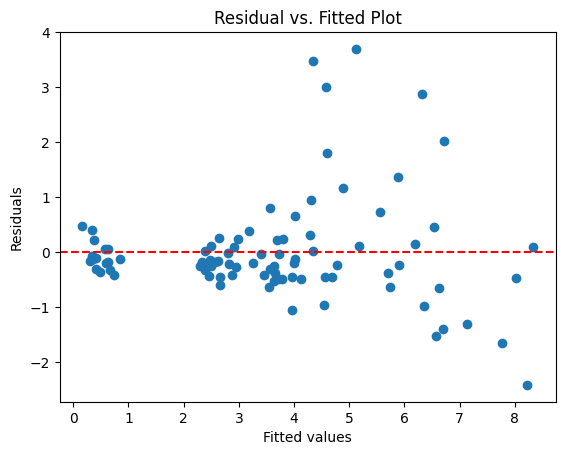

In [20]:
import matplotlib.pyplot as plt
plt.scatter(ols_res.fittedvalues, ols_res.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Plot')
plt.show()


In [30]:
from linearmodels.panel import compare
from linearmodels.panel import PanelOLS, RandomEffects


fe_model = PanelOLS(y, X, entity_effects=True)
fe_results = fe_model.fit()


re_model = RandomEffects(y, X)
re_results = re_model.fit()

result = compare({'FE': fe_results, 'RE': re_results})
print(result)


                             Model Comparison                            
                                                  FE                   RE
-------------------------------------------------------------------------
Dep. Variable                       Scaled Net sales     Scaled Net sales
Estimator                                   PanelOLS        RandomEffects
No. Observations                                  90                   90
Cov. Est.                                 Unadjusted           Unadjusted
R-squared                                     0.5130               0.8307
R-Squared (Within)                            0.5130               0.2774
R-Squared (Between)                          -4.4505               0.9882
R-Squared (Overall)                          -3.3506               0.8307
F-statistic                                   13.868               67.862
P-value (F-stat)                              0.0000               0.0000
=============================     ====

In [32]:
import numpy as np
import scipy.stats
from linearmodels.panel import PanelOLS, RandomEffects


fe_model = PanelOLS(y, X, entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
re_model = RandomEffects(y, X).fit()

b = fe_model.params
B = re_model.params
v_b = fe_model.cov
v_B = re_model.cov

diff = b - B
var_diff = v_b - v_B

chi2 = diff.T @ np.linalg.inv(var_diff) @ diff
p_value = 1 - scipy.stats.chi2.cdf(chi2, len(b))

print(f"Chi-squared: {chi2}")
print(f"P-value: {p_value}")



Chi-squared: 2.506274419875746
P-value: 0.9266238542884373


# t-4

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import RandomEffects

df_final_clean4 = df_final_clean.set_index(['Company', 'Year'])


df_final_clean4 = df_final_clean4.dropna(subset=['MDA sentiment t-4', 'average tweet sentiment t-4'])

df_final_clean4['Total assets'] = df_final_clean4['Total assets'].replace(0, np.nan)
df_final_clean4['Net sales'] = df_final_clean4['Net sales'].replace(0, np.nan)


df_final_clean4['ln_Total_assets'] = np.log(df_final_clean4['Total assets'])
df_final_clean4['ln_Net sales'] = np.log(df_final_clean4['Net sales'])


df_final_clean4['Scaled Total assets'] = df_final_clean4['Total assets'] / 10000
df_final_clean4['Net sales'] = df_final_clean4['Net sales'] / 10000
df_final_clean4['Scaled Total liability'] = df_final_clean4['Total liability'] / 10000
df_final_clean4['Scaled Net sales t-1'] = df_final_clean4['Net sales t-1'] / 10000

df_final_clean4['interaction'] = df_final_clean4['MDA sentiment t-4'] * df_final_clean4['average tweet sentiment t-4']

X = df_final_clean4[['average tweet sentiment t-4', 'ln_Total_assets', 'MDA sentiment t-4', 'Debt-to-Equity', 'Net sales t-1', 'interaction']]
X = sm.add_constant(X)
y = df_final_clean4['Net sales']


model = RandomEffects(y, X)
re_results = model.fit()

print(re_results.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:              Net sales   R-squared:                        0.8146
Estimator:              RandomEffects   R-squared (Between):              0.9921
No. Observations:                  85   R-squared (Within):               0.1984
Date:                Wed, Sep 04 2024   R-squared (Overall):              0.8146
Time:                        14:31:09   Log-likelihood                   -119.47
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      57.127
Entities:                           5   P-value                           0.0000
Avg Obs:                       17.000   Distribution:                    F(6,78)
Min Obs:                       17.000                                           
Max Obs:                       17.000   F-statistic (robust):             57.127
                            